# Agora Vectorization Practise
This notebook describes the practise of utilizing different vectorization methods to gain insight on how to use these.

The balanced dataset is used in order to train more quickly, since there are less records, but also prevent the model from getting biased. The main reason for this is that since the Agora dataset contains a lot more records with the category 'Drugs' than any other category, the model might be biased when trained on the whole dataset.

In [1]:
import pandas as pd
from preprocessing import PreProcessor
import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

pp = PreProcessor()
df = pd.read_csv('darkweb/Balanced_Sample_500.csv') #500 records of all categories
df.columns = ['recordID','Category','Item','categoryID']
df['Tokens'] = df.apply(lambda d: pp.preprocess(str(d['Item']), tokenize = True), axis = 1)
df.head()

,recordID,Category,Item,categoryID,Tokens
0,40127,Counterfeits/Watches,Emporio Armani - AR1610 Shell Case ceramic bra...,0,"[emporio, armani, ar, shell, case, ceram, brac..."
1,40126,Counterfeits/Watches,Cartier-Tank Ladies Brand: Cartier Series: Tan...,0,"[cartiertank, ladi, brand, cartier, seri, tank..."
2,40125,Counterfeits/Watches,Patek Philippe watch box ★ Patek Philippe - Wa...,0,"[patek, philipp, watch, box, patek, philipp, w..."
3,40130,Counterfeits/Watches,Breitling - NAVITIMER COSMONAUTE 【Replica】 Wat...,0,"[breitl, navitim, cosmonaut, replica, watch, i..."
4,40129,Counterfeits/Watches,Emporio Armani Men's AR0397 Dial color Gary Wa...,0,"[emporio, armani, men, ar, dial, color, gari, ..."


## Word2Vec
The first vectorization technique that will be used, is Word2vec.

In [2]:
from gensim.models import Word2Vec 
%matplotlib inline

model = Word2Vec(df['Tokens'], size = 100, window = 5, min_count = 10, workers=multiprocessing.cpu_count())
print(model)

Word2Vec(vocab=3256, size=100, alpha=0.025)


In [3]:
model['case']

array([ 0.82274723,  0.41782096,  0.52401346,  0.9497448 , -1.1327121 ,
       -2.3589234 , -1.4045594 ,  0.53448343, -0.5321414 , -0.61835736,
        0.17824297,  0.5263127 ,  0.8639696 ,  1.203617  , -0.137121  ,
       -1.0799682 ,  0.462793  ,  0.2240205 ,  0.37968555,  0.6940423 ,
        0.94746274,  0.586658  , -0.5619143 ,  0.30487236,  0.5660324 ,
        1.2426021 ,  0.7760685 ,  0.3930097 , -0.25060543,  0.07462775,
       -0.5023274 , -0.78922737, -0.5139283 ,  0.17035727, -0.8371855 ,
       -0.4179198 ,  0.51258   ,  0.810334  ,  0.09808992,  0.03379184,
       -0.1413404 , -1.1795164 ,  0.8024365 , -1.2623922 ,  0.9050148 ,
        0.34415558, -0.42290697,  1.689862  , -1.5901179 ,  1.2303368 ,
       -0.11184583,  0.2333569 , -0.26730824,  0.39830828, -0.10878523,
       -0.1463502 ,  0.48228255, -0.4114831 , -1.4598137 , -0.747567  ,
       -1.2590992 ,  0.25384632,  0.92260265,  0.85878336,  0.25982562,
        1.9035989 ,  0.5177705 ,  0.37870684, -0.31898892,  0.85

In [4]:
w2v_vectors = []
categories = []
for i, row in df.iterrows():
    v = [model[x] for x in row['Tokens'] if x in model]
    if len(v) > 0:
        w2v_vectors.append(v)
        categories.append(row['Category'])
    else:
        w2v_vectors.append([])
        categories.append(row['Category'])
    
vectors = []
for index, models in enumerate(w2v_vectors):
    if len(models) > 0:
        new_vectors = models[0]
        for v in models[1:]:
            new_vectors = new_vectors + v
        vectors.append(new_vectors.tolist())
    else:
        vectors.append([])

### Training the model (spectral clustering) (FAILED)
3256 words, 100 dimensions

In [5]:
import numpy as np

A = np.array(model)
#vals, vecs = np.linalg.eig(A)


### Training the model (K means)

In [6]:
X = model[model.wv.vocab]

In [7]:
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
kmeans = cluster.KMeans(n_clusters=100) #100 cluster for approx. 100 topics
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[67 67 67 ... 80 80 43]
Centroids data
[[ 0.15450764  0.07847963  0.07655963 ...  0.04025422 -0.556353
   0.02897911]
 [ 0.10310657  0.13289775  0.1028216  ...  0.03384883 -0.2988106
  -0.04332698]
 [ 0.08988695  0.17747594  0.09061391 ...  0.264672   -0.16111192
  -0.24856575]
 ...
 [ 0.00374498  0.43755126  0.51234174 ... -0.20571    -0.3614623
   0.2543688 ]
 [ 0.09503776  0.08162315  0.10259951 ...  0.13571079 -0.2227619
  -0.05988684]
 [-0.13002789  0.3290874  -0.48284438 ... -0.81925505 -0.5686619
  -0.05461225]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-4805.746
Silhouette_score: 
0.07219762


### T-SNE

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def w2v_tsne_plot(model):
    """Creates and TSNE model and plots it"""
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(" ",
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

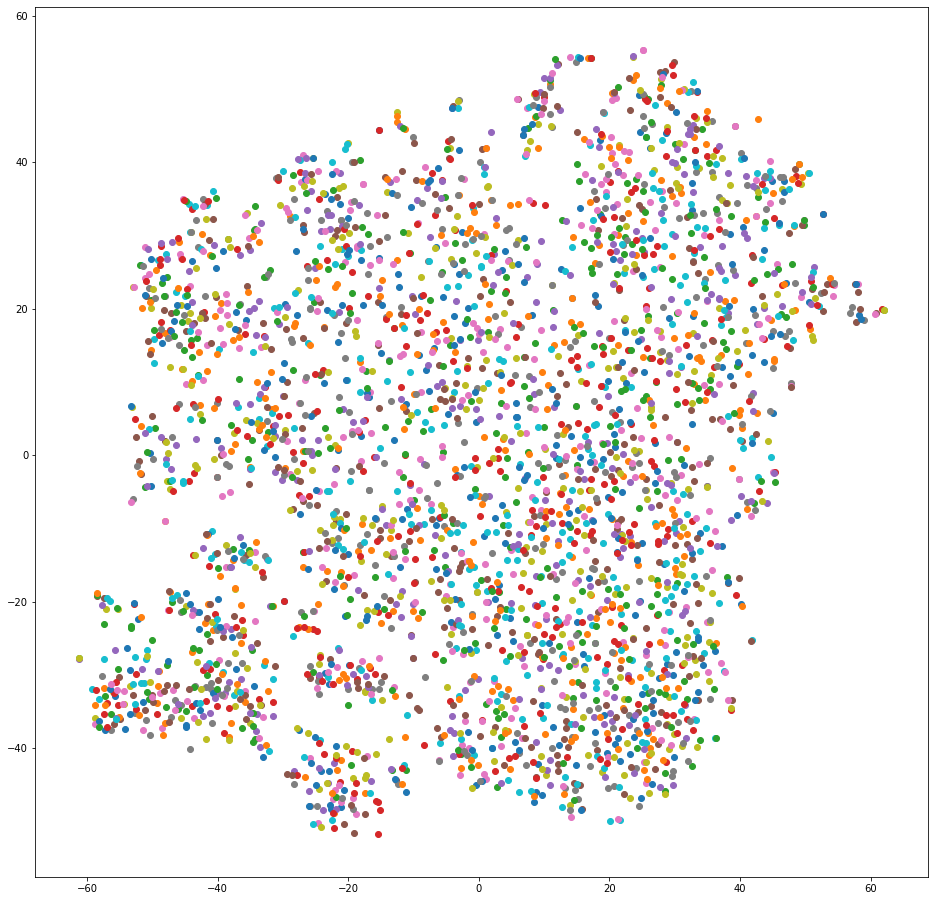

In [9]:
w2v_tsne_plot(model)

In [10]:
model.most_similar('hash')

[('moroccan', 0.9148752689361572),
 ('pollen', 0.894440770149231),
 ('polm', 0.8859169483184814),
 ('hashish', 0.8668975830078125),
 ('soft', 0.8519806861877441),
 ('bubbl', 0.8514620065689087),
 ('afghan', 0.798633337020874),
 ('chara', 0.7935138940811157),
 ('blond', 0.7895858287811279),
 ('ketama', 0.7829290628433228)]

## TD-IDF
Tfidftransformer and Tfidfvectorizer aim to do the same thing, which is to convert a collection of raw documents to a matrix of TF-IDF features. The only difference is that with Tfidftransformer, you will systematically compute the word counts, generate idf values and then compute a tfidf score or set of scores.

With Tfidfvectorizer, you will do all three steps at once. Under the hood, it computes the word counts, idf values, and tfidf scores all using the same dataset. Below you will find examples on how to use them individually.

In [11]:
# settings that you use for count vectorizer will go here
tfidf_vectorizer = TfidfVectorizer(use_idf = True)

# just send in all your docs here
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(df['Item'])

# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

In [12]:
df1 = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index = tfidf_vectorizer.get_feature_names(), columns = ["tfidf"])
df1.sort_values(by = ["tfidf"], ascending = False)

,tfidf
case,0.441489
ceramics,0.389212
material,0.352436
armani,0.306461
millimeters,0.246671
...,...
distributed,0.000000
distribute,0.000000
distorting,0.000000
distorted,0.000000


In [13]:
df1.loc['case']

tfidf    0.441489
Name: case, dtype: float64

## KMeans

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
random = 42

vec = TfidfVectorizer(stop_words="english")
vec.fit(df['Item'].values)
features = vec.transform(df['Item'].values)

cls = MiniBatchKMeans(n_clusters=5, random_state = random)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [15]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

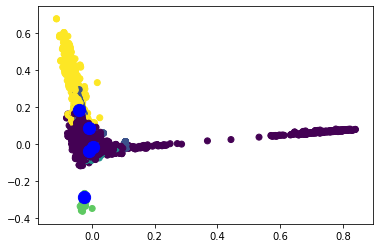

In [16]:
import matplotlib.pyplot as plt

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], s=150, c='b')

In [17]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df['Category'], cls.predict(features))

0.13593890329075206